# 2021 제 1회 데이터과학부 데이터분석 경진대회
- 18016019 김수현
- 19016002 고가연
- 19016070 이수현


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = 200
#한글설정
import matplotlib.font_manager as fm
#show all
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
    
# 한글 출력을 위해서 폰트 옵션 설정
font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# "axes.unicode_minus" : 마이너스가 깨질 것을 방지
sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid',
        palette='Set2')

# 1. DATA

In [2]:
path = './data/'
data = pd.read_excel(path + '경진대회용데이터.xlsx')

## 1.1 데이터 가공

In [3]:
#함수를 이용해서 데이터 가공
def process(data):
    
    #작목코드 제거
    #'q2_1_1','q2_2_1','q2_3_1','q2_4_1','q2_5_1','q2_6_1' 하나의 열로 합치기
    data['q2'] = data[['q2_1_1','q2_2_1','q2_3_1','q2_4_1','q2_5_1','q2_6_1']].rename(
                    columns={'q2_1_1':0, 'q2_2_1':1,'q2_3_1':2,'q2_4_1':3,'q2_5_1':4,'q2_6_1':5}).idxmin(axis=1)
    data['q2_1_1'] = data['q2']
    data = data.drop(['q1_2','q2','q2_2_1','q2_3_1','q2_4_1','q2_5_1','q2_6_1'], axis=1)
    data = data.rename(columns={'q2_1_1':'q2'})

    #q2_1_2 q2_2_2 q2_3_2 q2_4_2 규모 - 하나의 열로 합치기
    temp = data.copy().fillna(0)
    data['q2_1_2'] = temp['q2_1_2'] + temp['q2_2_2'] + temp['q2_3_2'] + temp['q2_4_2']
    data = data.rename(columns = {'q2_1_2':'규모'}).drop(['q2_2_2','q2_3_2','q2_4_2'], axis=1)

    #컬럼 rename
    data = data.rename(columns={'q1_1':'작목','q2':'농업종류','q3':'총소득','q4':'농업소득비율','q5':'거주인구','q7':'농업종사율',
                                'q8':'경영주관계','q9':'성별','q10':'나이','q11':'종사기간','q12':'작년종사기간','q13':'농업제한',
                                'q14':'동력기계조작여부','q17':'농약사용','q26':'사다리사용','q26_1_1':'사다리사고',
                                'q26_1_2':'사다리사고횟수', 'q28':'농자재무게감소동의','q28_1_1':'농자재사고여부',
                                'q28_1_2':'농자재사고횟수', 'q29_2_1':'농기계사고여부','q29_2_2':'농기계사고횟수',
                                'q32':'사고/치료여부','q32_1':'사고관련성','q2_5_2_1':'소','q2_5_2_2':'돼지',
                                'q2_5_2_3':'닭','q2_5_2_4':'기타', 'q8etc':'경영주관계기타','aq1_1': '사고발생월',
                                'aq2_1': '사고발생시간', 'aq3_1': '사고발생날씨', 'aq4_1': '사고발생장소', 'aq5_1': '사고발생상황',
                                'aq6_1': '사고발생경위', 'aq7_1_1': '농기계관련여부', 'aq7_2_1': '농기구관련여부',
                                'aq8_1_1': '부상부위','aq8_1_2': '부상종류', 'aq9_1': '강제휴식기여부', 'aq9_1_1': '강제휴식기간',
                                'aq10_1': '치료기간','aq11_1': '회복정도','gagu_n':'농업참여인구',
                                'q2_5_2_4etc':'축산_기타', 'q2_6_1etc':'농업_기타','q2_6_2':'기타_규모',
                                'aq9_1_1etc':'휴식기간_자세히'})

    #필요 없는 컬럼 삭제
    data = data.drop(['id','re1','q1_1re','age','age2'], axis=1)
    
    #축산_기타에 대한 이상치 수정
    data['축산_기타'] = data['축산_기타'].replace(0, np.nan).replace(2, np.nan).replace('청계닭', np.nan).replace('염소27','염소')
    data.at[data[data['축산_기타']=='청계닭'].index, '닭'] = 30
    data.at[data[data['축산_기타']=='염소27'].index, '기타'] = 27
    
    #경영주관계기타에 대한 이상치 수정 
    data.at[data[data['경영주관계기타'].isin(['며느리','경영주의 며느리'])].index, '경영주관계'] = 3
    data.at[data[data['경영주관계기타'].isin(['처남','오빠','시누이','시동생','형수'])].index, '경영주관계'] = 7
    data.drop('경영주관계기타',axis=1, inplace=True)
    
    #의미 없는 컬럼 drop
    data = data.drop(['aq3_1etc','aq4_1etc','aq5_1etc','aq6_1etc','aq8_1_1etc','aq8_1_2etc'], axis=1)
    
    #농업_기타에 대한 이상치 수정
    data['농업_기타'] = data['농업_기타'].replace(1, np.nan)

    #의식 관련 컬럼 추출 + 데이터에서 의식 관련 컬럼 제거
    cols = ['q20', 'q22', 'q23', 'q24', 'q25_1', 'q25_2', 'q25_3', 'q25_4', 'q25_5',
           'q25_6', 'q27_1', 'q27_2', 'q27_3', 'q27_4', 'q27_5', 'q27_6', 'q27_7',
           'q27_8', 'q27_9', 'q27_10', 'q29_1_1', 'q29_1_2', 'q30', 'q30_1',
           'q31_1', 'q31_2', 'q31_3', 'q31_4', 'q31_5']
    의식df = data[cols]
    data = data.drop(cols, axis=1)
    
    #나이 범주화
    def age(x):
        if x<30:
            return 20
        elif x>=30 and x<40:
            return 30
        elif x>=40 and x<50:
            return 40
        elif x>=50 and x<60:
            return 50
        elif x>=60 and x<70:
            return 60
        elif x>=70 and x<80:
            return 70
        elif x>=80 and x<90:
            return 80
        else:
            return 90
        
    data['나이'] = data['나이'].apply(lambda x:age(x))
    
    #손상자/비손상자 구분을 위한 컬럼 추가 - 추가손상조사표 작성한 농업인을 손상자로 정의
    damaged_idx = data[data['사고발생월'].notnull()].index
    data['damaged'] = 0
    data.loc[damaged_idx,'damaged'] = 1
    
    #reset_index
    data = data.reset_index(drop = True)
    의식df = 의식df.reset_index(drop = True)
    
    #가공된 데이터와 의식df 리턴
    return data, 의식df

data, 의식df = process(data)

## 1.2 new의식df 생성 및 저장

In [4]:
new의식df = 의식df.drop(columns = ['q25_1', 'q25_2', 'q25_3', 'q25_4', 'q25_5', 'q25_6', 'q27_2', 'q27_5', 'q29_1_1', 'q29_1_2'], axis = 1)
new의식df

,q20,q22,q23,q24,q27_1,q27_3,q27_4,q27_6,q27_7,q27_8,q27_9,q27_10,q30,q30_1,q31_1,q31_2,q31_3,q31_4,q31_5
0,1,2,1,1,2,4,5,5,5,5,5,5,2,1.0,2,2,2,2,2
1,2,2,1,1,4,4,4,4,4,4,4,4,2,1.0,1,1,1,1,1
2,2,2,1,1,3,4,4,4,4,4,4,4,2,2.0,1,2,1,2,2
3,2,2,4,1,4,4,4,4,4,4,4,4,2,3.0,1,2,1,2,2
4,1,1,4,1,4,4,4,4,4,4,4,4,2,2.0,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17765,2,2,1,1,4,5,5,5,5,5,5,5,3,NaN,2,2,2,2,2
17766,4,2,1,1,1,5,4,4,5,5,5,5,3,NaN,2,2,2,2,2
17767,2,1,1,1,4,5,5,5,5,5,5,5,3,NaN,2,2,2,2,2
17768,2,1,1,1,4,5,5,5,5,5,5,5,3,NaN,2,2,2,2,2


In [5]:
#의식 높을 수록 내림차순으로 점수를 정의하기 위해, 데이터 값 역순으로 재정의
desc = new의식df[['q20', 'q22', 'q30', 'q30_1']]

for i in desc.columns:
    if desc[i].nunique() == 4:
        for j,k in enumerate(desc[i]):
            if k == 4:
                desc[i][j]=1
            elif k == 3:
                desc[i][j]=2
            elif k == 2:
                desc[i][j]=3
            elif k == 1:
                desc[i][j]=4
    elif desc[i].nunique() == 5:
        for j,k in enumerate(desc[i]):
            if k == 5:
                desc[i][j]=1
            elif k == 4:
                desc[i][j]=2
            elif k == 3:
                desc[i][j]=3
            elif k == 2:
                desc[i][j]=4
            elif k == 1:
                desc[i][j]=5
                
new의식df[desc.columns] = desc

#특정 문항 1점과 3점으로만 구성되도록 점수 재정의
for i in new의식df.columns:
    if '31' in i:
        for j in range(len(new의식df[i])):
            if (new의식df[i][j] == 1) or (new의식df[i][j] == 3):
                new의식df[i][j] = 3
            elif new의식df[i][j] == 2:
                new의식df[i][j] = 1

# 저장
# new의식df.to_csv(path + "new의식df.csv", index=False)

## 1.3 분석을 위한 데이터 생성 - `visual_data`
- 분석시각화 편의를 위해 데이터 값들을 한글로 변환 후 저장

In [6]:
df = data.copy()

농업종류 = {0:'논',1:'밭',2:'과수원',3:'시설(하우스)',4:'축산',5:'기타'}
총소득 = {1:'x<500만',2:'500만<=x<2000만',3:'2000만<=x<5000만',4:'5000만<=x'}

농업소득비율 = {1:'x<=25%',2:'26%~50%',3:'51%~75%',4:'76%~100%'}

농업종사율 = {1:'전업농',2:'농업이주업',3:'농업이부업'}

경영주관계 = {1:'경영주',2:'경영주의배우자',3:'경영주의부모',4:'경영주의조부모',5:'경영주의자녀',6:'경영주의손자',7:'경영주의형제',8:'기타'}

성별 = {1:'남성',2:'여성'}
작년종사기간 = {1:'1~2개월',2:'3~5개월',3:'6~8개월',4:'9개월이상'}
농업제한 = {1:'전혀없음',2:'조금있음',3:'보통있음',4:'매우있음'}
동력기계조작여부 = {1:'예',2:'아니오'}

농약사용 = {1:'해당없음',2:'대행',3:'직접살포',4:'간접작업',5:'직접or간접'}
사다리사용 = {1:'일주일3회이상',2:'일주일1~2회',3:'한달에1~3회',4:'한달에1회미만',5:'없음'}
사다리사고 = {1:'없다',2:'있다'}
농자재무게감소동의 = {1:'매우동의',2:'동의',3:'동의안함',4:'절대동의안함'}
농자재사고여부 = {1:'없다',2:'있다'}
농기계사고여부 = {1:'없다',2:'있다'}
치료여부 = {1:'없다',2:'있다'}
사고관련성 = {1:'관련사고',2:'비관련사고',3:'타인의폭력',4:'의도적자해'}

#사고발생날씨
날씨 = {1:'맑음', 2:'비', 3:'눈', 4:'안개', 5:'바람', 6:'더위(폭염)', 7:'추위(한파)',
        8:'천둥/번개', 9:'우박', 10:'기타'}
#사고발생장소
장소 = {1:'집', 2:'비포장농로', 3:'포장된농로', 4:'일반도로', 5:'논진출입로',
        6:'논두렁',7:'논',8:'밭진출입로',9:'밭',10:'경사형과수원',11:'평지형과수원',12:'시설(비닐하우스)내부',
        13:'시설(비닐하우스)외부',14:'축사내부', 15:'축사외부',16:'창고/저장고', 17:'기타'}
상황 = {1:'농작업준비중',2:'농작업중',3:'농작업후정리중',4:'농작업관련이동중',5:'가공/포장/운반',
        6:'농생산물운송/판매과정',7:'농기계관련점검/정비',8:'기타농작업 장치/시설관련', 9:'기타'}

사고경위 = {1:'차대차교통사고',2:'운전사고',3:'넘어짐/미끄러짐',4:'추락사고',5:'무리한힘/동작',
            6:'낙하/비례', 7:'충돌',8:'베임/찔림',9:'끼임/감김', 10:'동물',11:'농약/유해물질중독',12:'고온저온노출',
            13:'보행교통사고',14:'기타'}

농기계사고여부 = {1:'있다',2:'없다'}
농기구관련여부 = {1:'있다',2:'없다'}
부상부위 = {1:'손가락',2:'손',3:'손목',4:'팔',5:'상지',6:'발가락',7:'발',8:'발목',9:'다리',
            10:'하지',11:'흉부',12:'등',13:'복부',14:'어깨',15:'골반',16:'몸통', 17:'머리',18:'얼굴',
            19:'치아',20:'목',21:'두부',22:'척추',23:'신체',24:'기타'}
강제휴식여부 = {1:'있다',2:'없다'}
치료여부 = {1:'있다',2:'없다'}
회복여부 = {1:'지장없음', 2:'약간떨어짐',3:'많이떨어짐',4:'전혀못함'}
부상종류 = {1:'긁힘/찰과상', 2:'찔림',3:'타박상/멍',4:'삠/접질림',5:'베임',6:'신체절단',
            7:'골절',8:'탈구',9:'근육/인대파열',10:'허리/목디스크',11:'뇌진탕 등',12:'농약중독',13:'동물',
            14:'청력상실',15:'시력상실',16:'화상',17:'산소결핍/질식',18:'감전',19:'복합손상',20:'기타'}

def func(col, dic):
    df[col] = df[col].apply(lambda x:dic[x] if x in dic else np.nan)

func('농업종류', 농업종류)
func('총소득', 총소득)
func('농업소득비율', 농업소득비율)
func('농업종사율', 농업종사율)
func('경영주관계', 경영주관계)
func('성별', 성별)
func('작년종사기간', 작년종사기간)
func('농업제한', 농업제한)
func('동력기계조작여부', 동력기계조작여부)
func('농약사용', 농약사용)

func('사다리사용', 사다리사용)
func('사다리사고', 사다리사고)
func('농자재무게감소동의', 농자재무게감소동의)
func('농기계사고여부', 농기계사고여부)
func('농자재사고여부', 농자재사고여부)
func('사고/치료여부', 치료여부)
func('사고관련성', 사고관련성)
func('사고발생날씨', 날씨)
func('사고발생장소', 장소)
func('사고발생상황', 상황)

func('사고발생경위', 사고경위)
func('농기구관련여부', 농기구관련여부)
func('부상부위', 부상부위)
func('강제휴식기여부', 강제휴식여부)
func('치료기간', 치료여부)
func('회복정도', 회복여부)
func('부상종류', 부상종류)

def rest_period(x):
    if x>=1 and x<11:
        return '1~10일'
    elif x>=11 and x<21:
        return '11~20일'
    elif x>=21 and x<31:
        return '21~30일'
    elif x>=31 and x<61:
        return '31~60일'
    elif x>=61 and x<91:
        return '61~90일'
    else:
        return '91일이상'
df['휴식기간범주화'] = df['휴식기간_자세히'].apply(lambda x:rest_period(x))

# df.to_csv(path + 'visual_data.csv',index=False)

# 2. 안전의식과 손상의 상관관계
## 2.1 의식문항 추리는 기준정해서 줄이기
- 'q20', 'q22', 'q30' : 1~4점 문항 (3개)
- 'q23', 'q24', 'q27_1', 'q27_3', 'q27_4', 'q27_6', 'q27_7','q27_8', 'q27_9', 'q27_10' : 1~5점 문항 (10개)
- 'q31_1', 'q31_2', 'q31_3','q31_4', 'q31_5' : 1,3점 문항 (5개)
- 'q30_1' : nan값이 있어서 제외

In [7]:
visual = pd.read_csv(path + 'visual_data.csv')
의식df = pd.read_csv(path +'new의식df.csv')
의식df['damaged'] = visual['damaged']
의식df

,q20,q22,q23,q24,q27_1,q27_3,q27_4,q27_6,q27_7,q27_8,q27_9,q27_10,q30,q30_1,q31_1,q31_2,q31_3,q31_4,q31_5,damaged
0,4,3,1,1,2,4,5,5,5,5,5,5,3,5.0,1,1,1,1,1,0
1,3,3,1,1,4,4,4,4,4,4,4,4,3,5.0,3,3,3,3,3,0
2,3,3,1,1,3,4,4,4,4,4,4,4,3,4.0,3,1,3,1,1,0
3,3,3,4,1,4,4,4,4,4,4,4,4,3,3.0,3,1,3,1,1,0
4,4,4,4,1,4,4,4,4,4,4,4,4,3,4.0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17765,3,3,1,1,4,5,5,5,5,5,5,5,2,NaN,1,1,1,1,1,0
17766,1,3,1,1,1,5,4,4,5,5,5,5,2,NaN,1,1,1,1,1,0
17767,3,4,1,1,4,5,5,5,5,5,5,5,2,NaN,1,1,1,1,1,0
17768,3,4,1,1,4,5,5,5,5,5,5,5,2,NaN,1,1,1,1,1,0


## 2.2 선지 4개 문항 비율 비교 (3개)

In [8]:
# nan값이 있는 q30_1 제외
의식df1 = 의식df[['q20', 'q22', 'q23', 'q24', 'q27_1', 'q27_3', 'q27_4', 'q27_6', 'q27_7',
              'q27_8', 'q27_9', 'q27_10', 'q30', 'q31_1', 'q31_2', 'q31_3','q31_4', 'q31_5','damaged']]

손상자con = 의식df1[의식df1['damaged']==1]
비손상자con = 의식df1[의식df1['damaged']==0]

def rate_diff(선지4개):
    a = pd.DataFrame(손상자con[선지4개].value_counts()/sum(손상자con[선지4개].value_counts())*100)
    a = a.rename(columns={선지4개:('손상'+선지4개)})
    b = pd.DataFrame(비손상자con[선지4개].value_counts()/sum(비손상자con[선지4개].value_counts())*100)
    b = b.rename(columns={선지4개:('비손상'+선지4개)})
    ab = pd.concat([a,b],axis=1)
    diff = ab.loc[[3,4],ab.columns[0]].sum() - ab.loc[[3,4],ab.columns[1]].sum()
    print(f'{선지4개}의 손상자와 비손상자의 3,4점 문항 비율합의 차이는 {round(diff,2)}')
    
선지4개 = ['q20','q22','q30']
for i in 선지4개:
    rate_diff(i)

q20의 손상자와 비손상자의 3,4점 문항 비율합의 차이는 16.48
q22의 손상자와 비손상자의 3,4점 문항 비율합의 차이는 3.21
q30의 손상자와 비손상자의 3,4점 문항 비율합의 차이는 2.03


## 2.3 선지 5개 문항 비율 비교 (10개)

In [9]:
의식df1 = 의식df[['q20', 'q22', 'q23', 'q24', 'q27_1', 'q27_3', 'q27_4', 'q27_6', 'q27_7',
              'q27_8', 'q27_9', 'q27_10', 'q30', 'q31_1', 'q31_2', 'q31_3','q31_4', 'q31_5','damaged']]

손상자con = 의식df1[의식df1['damaged']==1]
비손상자con = 의식df1[의식df1['damaged']==0]


선지5개 = ['q23', 'q24', 'q27_1', 'q27_3', 'q27_4', 'q27_6', 'q27_7','q27_8', 'q27_9', 'q27_10']

def rate_diff(선지5개):
    a = pd.DataFrame(손상자con[선지5개].value_counts()/sum(손상자con[선지5개].value_counts())*100)
    a = a.rename(columns={선지5개:('손상'+선지5개)})
    b = pd.DataFrame(비손상자con[선지5개].value_counts()/sum(비손상자con[선지5개].value_counts())*100)
    b = b.rename(columns={선지5개:('비손상'+선지5개)})
    ab = pd.concat([a,b],axis=1)
    diff1 = ab.loc[[4,5],ab.columns[0]].sum() - ab.loc[[4,5],ab.columns[1]].sum()
    print(f'{선지5개}의 4,5점 문항 비율합 차 : {round(diff1,2)}')
    diff2 = ab.loc[[3],ab.columns[0]].sum() - ab.loc[[3],ab.columns[1]].sum()
    print(f'{선지5개}의 3점 문항 비율합 차 : {round(diff2,2)}')
    print('--------------')

for i in 선지5개:
    rate_diff(i)

q23의 4,5점 문항 비율합 차 : 4.41
q23의 3점 문항 비율합 차 : 2.45
--------------
q24의 4,5점 문항 비율합 차 : 5.9
q24의 3점 문항 비율합 차 : 0.93
--------------
q27_1의 4,5점 문항 비율합 차 : -1.8
q27_1의 3점 문항 비율합 차 : -0.63
--------------
q27_3의 4,5점 문항 비율합 차 : -1.3
q27_3의 3점 문항 비율합 차 : 1.0
--------------
q27_4의 4,5점 문항 비율합 차 : -2.88
q27_4의 3점 문항 비율합 차 : 1.63
--------------
q27_6의 4,5점 문항 비율합 차 : -1.86
q27_6의 3점 문항 비율합 차 : 1.95
--------------
q27_7의 4,5점 문항 비율합 차 : -6.41
q27_7의 3점 문항 비율합 차 : 1.64
--------------
q27_8의 4,5점 문항 비율합 차 : -4.28
q27_8의 3점 문항 비율합 차 : 1.94
--------------
q27_9의 4,5점 문항 비율합 차 : -4.97
q27_9의 3점 문항 비율합 차 : 1.52
--------------
q27_10의 4,5점 문항 비율합 차 : -1.48
q27_10의 3점 문항 비율합 차 : 1.26
--------------


## 2.4 선지 1or3 문항 비율 비교 (5개)

In [10]:
의식df1 = 의식df[['q20', 'q22', 'q23', 'q24', 'q27_1', 'q27_3', 'q27_4', 'q27_6', 'q27_7',
              'q27_8', 'q27_9', 'q27_10', 'q30', 'q31_1', 'q31_2', 'q31_3','q31_4', 'q31_5','damaged']]

손상자con = 의식df1[의식df1['damaged']==1]
비손상자con = 의식df1[의식df1['damaged']==0]

선지1or3 = ['q31_1', 'q31_2', 'q31_3', 'q31_4','q31_5']

def rate_diff(선지1or3):
    a = pd.DataFrame(손상자con[선지1or3].value_counts()/sum(손상자con[선지1or3].value_counts())*100)
    a = a.rename(columns={선지1or3:('손상'+선지1or3)})
    b = pd.DataFrame(비손상자con[선지1or3].value_counts()/sum(비손상자con[선지1or3].value_counts())*100)
    b = b.rename(columns={선지1or3:('비손상'+선지1or3)})
    ab = pd.concat([a,b],axis=1)
    diff1 = ab.loc[[3],ab.columns[0]].sum() - ab.loc[[3],ab.columns[1]].sum()
    print(f'{선지1or3}의 3점 문항 비율합 차 : {round(diff1,2)}')
    
for i in 선지1or3:
    rate_diff(i)

q31_1의 3점 문항 비율합 차 : 7.47
q31_2의 3점 문항 비율합 차 : 4.29
q31_3의 3점 문항 비율합 차 : 8.2
q31_4의 3점 문항 비율합 차 : 3.32
q31_5의 3점 문항 비율합 차 : 2.15


3.005207920792079

2.9391821604401516

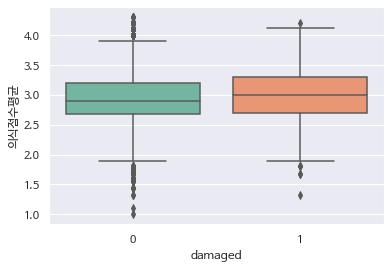

In [11]:
## 차이 상위 10개 의식수준 violin plot / box plot

visual = pd.read_csv(path + 'visual_data.csv')
의식df = pd.read_csv(path + 'new의식df.csv')
의식df['damaged'] = visual['damaged']

의식_v1 = 의식df.copy()
의식_v1 = 의식_v1[['q20', 'q23', 'q24', 'q27_7','q27_8', 'q27_9', 'q30_1', 'q31_1', 'q31_2', 'q31_3','damaged']]
의식_v1['의식점수평균'] = round(의식_v1.iloc[:, 0:-1].mean(axis = 1),2)
의식_v1 = 의식_v1[['의식점수평균','damaged']]

# 손상자/비손상자별 의식점수평균 비교
의식_v1[의식_v1['damaged']==1]['의식점수평균'].mean()
의식_v1[의식_v1['damaged']==0]['의식점수평균'].mean()

ax = sns.boxplot(x="damaged", y="의식점수평균", data=의식_v1)

## 2.5 차이 상위 10개 의식수준 violin plot / box plot

3.005207920792079

2.9391821604401516

<Figure size 500x300 with 0 Axes>

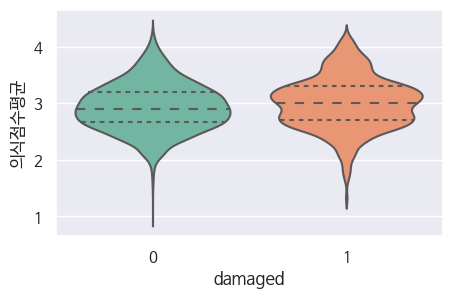

In [12]:
의식_v1 = 의식df.copy()
의식_v1 = 의식_v1[['q20', 'q23', 'q24', 'q27_7','q27_8', 'q27_9', 'q30_1', 'q31_1', 'q31_2', 'q31_3','damaged']]
의식_v1['의식점수평균'] = round(의식_v1.iloc[:, 0:-1].mean(axis = 1),2)
의식_v1 = 의식_v1[['의식점수평균','damaged']]

# 손상자/비손상자별 의식점수평균 비교
의식_v1[의식_v1['damaged']==1]['의식점수평균'].mean()
의식_v1[의식_v1['damaged']==0]['의식점수평균'].mean()

plt.figure(figsize=(5,3),dpi=100)
ax = sns.violinplot(x="damaged", y="의식점수평균",
                    data=의식_v1, palette="Set2", split=True,
                     inner="quartile",
                    scale_hue=False, bw=.2)

# ax = sns.boxplot(x="damaged", y="의식점수평균",
#                     data=의식_v1,palette="Set2")


## 2.6 차이 상위 10개 column으로 검정
- 유의함

In [13]:
의식_v1 = 의식df.copy()
의식_v1 = 의식_v1[['q20', 'q23', 'q24', 'q27_7','q27_8', 'q27_9', 'q30_1', 'q31_1', 'q31_2', 'q31_3','damaged']]

# 의식_v1

의식_v1['의식점수평균'] = round(의식_v1.iloc[:, 0:-1].mean(axis = 1),2)
의식_v1 = 의식_v1[['의식점수평균','damaged']]

# 손상자/비손상자별 의식점수평균 비교
의식_v1[의식_v1['damaged']==1]['의식점수평균'].mean()
의식_v1[의식_v1['damaged']==0]['의식점수평균'].mean()

from scipy import stats

손상sample = list(의식_v1[의식_v1['damaged']==1]['의식점수평균'])
비손상sample = list(의식_v1[의식_v1['damaged']==0]['의식점수평균'])

# 모수적 검정(parametric test)
test, p_value = stats.ttest_ind(손상sample, 비손상sample) # Two sample t-test
print('Ttest_indResult : ',round(p_value,8))

# 비모수적 검정(non-parametric test)
test, p_value = stats.ranksums(손상sample, 비손상sample) # Wilcoxon rank sum test
print('RanksumsResult : ',round(p_value,8))

test, p_value = stats.mannwhitneyu(손상sample, 비손상sample) # Mann–Whitney U test
print('MannwhitneyuResult : ',round(p_value,8))

3.005207920792079

2.9391821604401516

Ttest_indResult :  0.00054998
RanksumsResult :  0.00040025
MannwhitneyuResult :  0.0001972


# 3. 손상자 및 비손상자 분석

In [14]:
#시각화를 위한 함수 생성
def visual_percentage(data, col, order=None, figsize=None, legend_loc = 'upper right'):
    fig = plt.figure(figsize=figsize, dpi=100)

    x, y, hue = col, "percentage(%)", "damaged"
    hue_order = [0, 1]

    (data[x]
     .groupby(data[hue])
     .value_counts(normalize=True)
     .mul(100)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, order=order))

    plt.legend(loc=legend_loc)
    plt.xticks(rotation=90)

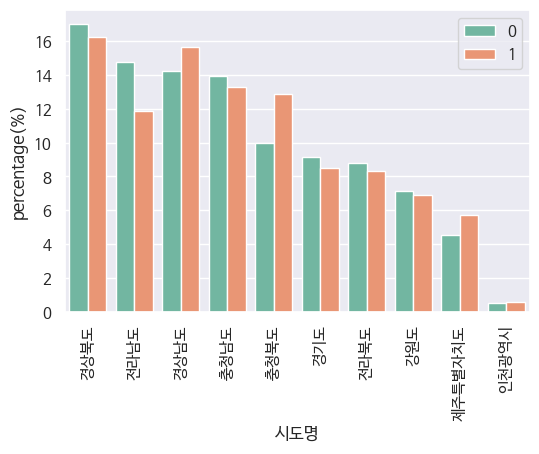

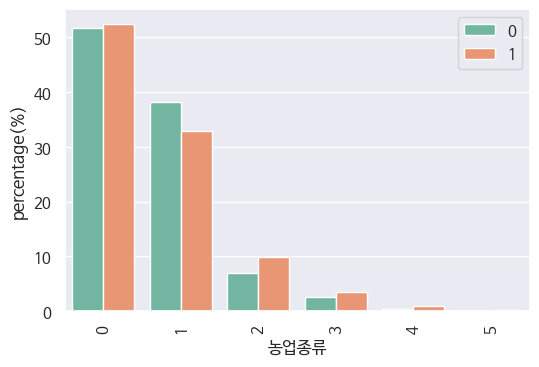

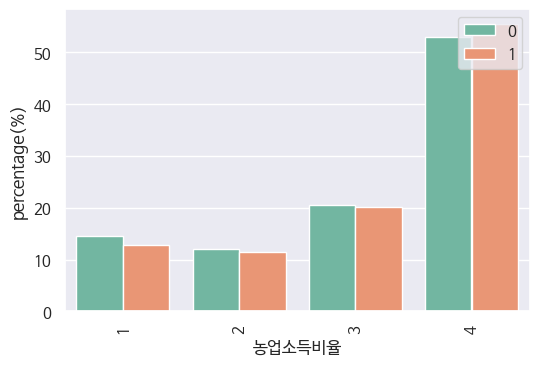

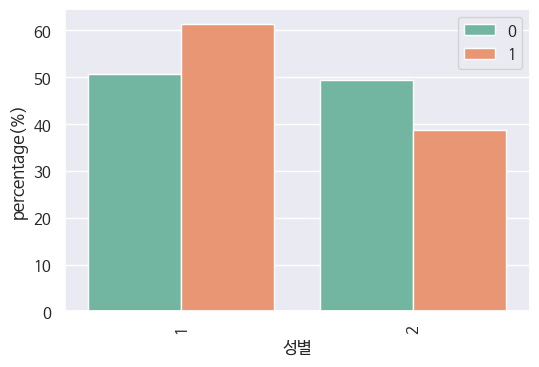

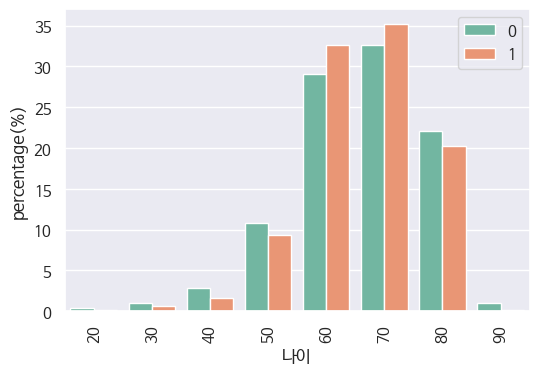

In [15]:
data = pd.read_csv(path + 'visual_data.csv')

범주형x = ['시도명', '농업종류', '농업소득비율', '성별', '나이']

for i in 범주형x:
    visual_percentage(data, i)

# 4. 손상자 패턴분석
- 다양한 변수를 사용해서 손상자의 패턴을 분석하기 위해 클러스터링 분석을 수행한다.
- **클러스터 개수를 2개**로 지정해 각 변수에 대해 두 개의 그룹으로 분리, 각 그룹에 대한 패턴을 분석하였다.

In [16]:
#클러스터링 시각화를 위해 함수 생성
def visual_cluster(data, col, order=None, figsize=None, legend_loc = 'upper right'):
    fig = plt.figure(figsize=figsize, dpi=100)

    x, y, hue = col, "percentage(%)", "cluster"
    hue_order = [0, 1]

    (data[x]
     .groupby(data[hue])
     .value_counts(normalize=True)
     .mul(100)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, order=order))

    plt.legend(loc=legend_loc)
    plt.xticks(rotation=90)

In [17]:
from sklearn.cluster import KMeans
import collections

data = pd.read_csv(path + 'visual_data.csv')

def clustering(data, col):
    df = data[data['damaged']==1].fillna(0).reset_index(drop=True)
    df1 = df[col]
    df1 = pd.get_dummies(df1)
    model = KMeans(n_clusters=2, 
               init='k-means++', 
               n_jobs=-1, 
               random_state=1) 
    model.fit(df1)
    y = model.predict(df1)
    print(collections.Counter(y))
    df['cluster'] = y
    return df

## 4.1 연령대가 높은 그룹, 낮은 그룹

Counter({1: 281, 0: 224})


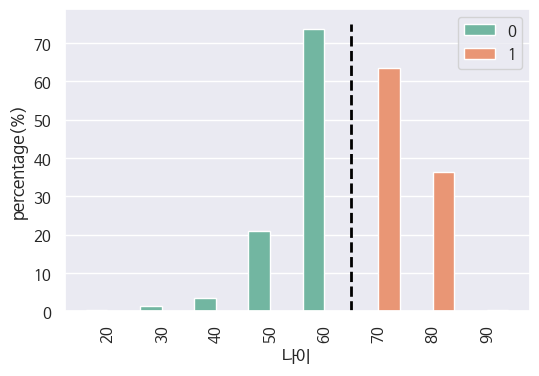

In [18]:
나이 = clustering(data, ['나이'])
visual_cluster(나이, '나이')
plt.plot([4.5,4.5], [0,75], 'k--', lw=2)

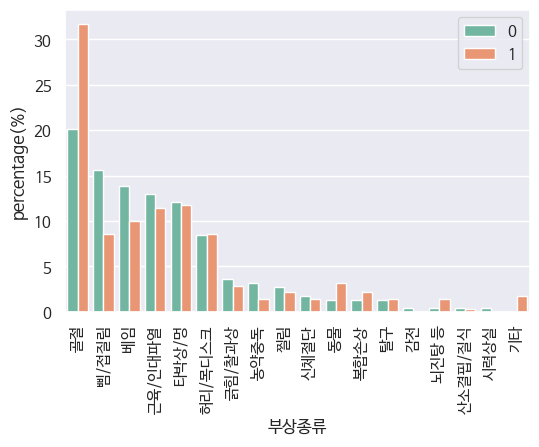

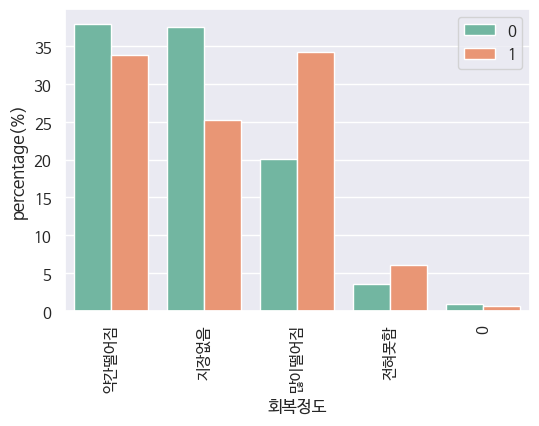

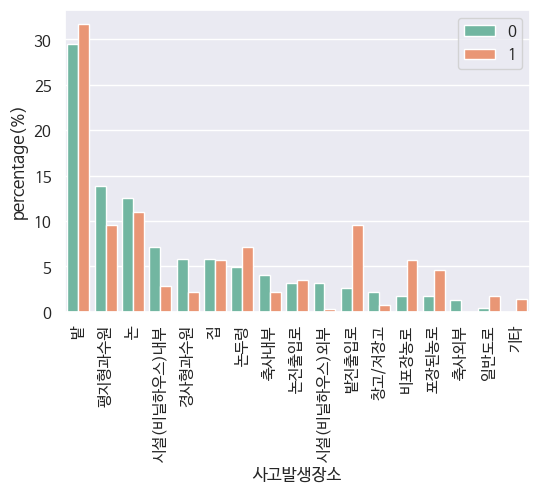

In [19]:
cols = ['부상종류','회복정도','사고발생장소']
for i in cols:
    visual_cluster(나이, i)

## 4.2 휴식기간 긴 그룹, 짧은 그룹

Counter({0: 401, 1: 104})


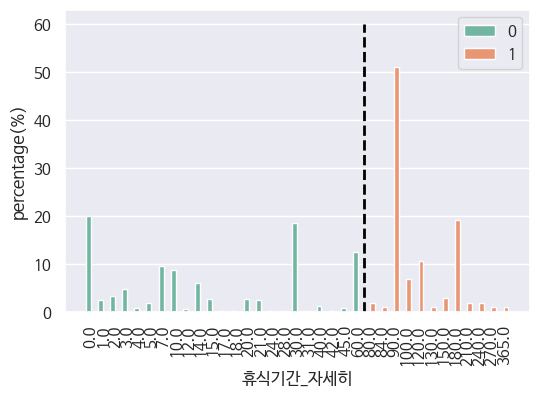

In [20]:
휴식기간 = clustering(data, ['휴식기간_자세히'])
visual_cluster(휴식기간, '휴식기간_자세히')
plt.plot([22.5,22.5], [0,60], 'k--', lw=2)

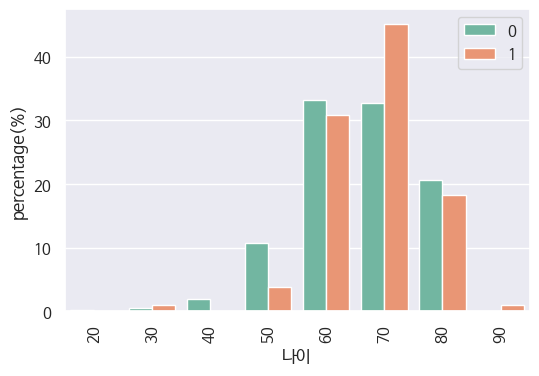

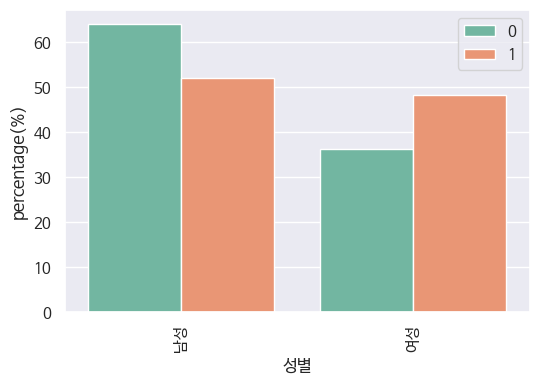

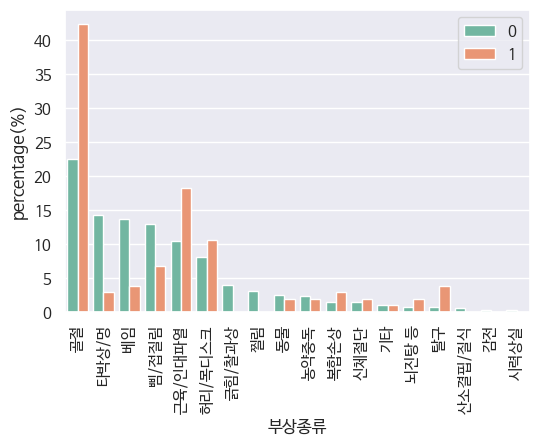

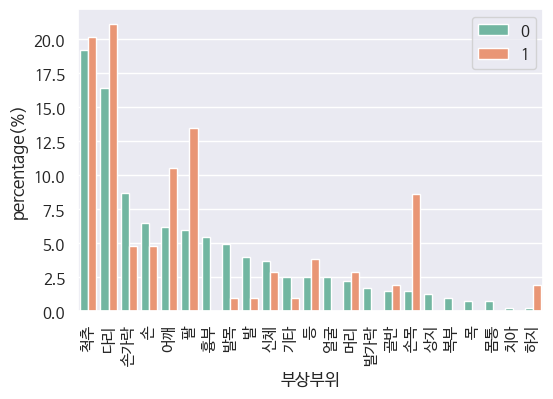

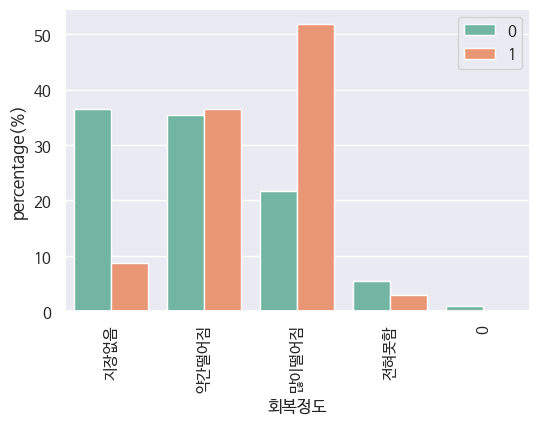

In [21]:
cols = ['나이','성별','부상종류','부상부위','회복정도']
for i in cols:
    visual_cluster(휴식기간, i)

## 4.3 종사기간 긴 그룹, 짧은 그룹

Counter({0: 337, 1: 168})


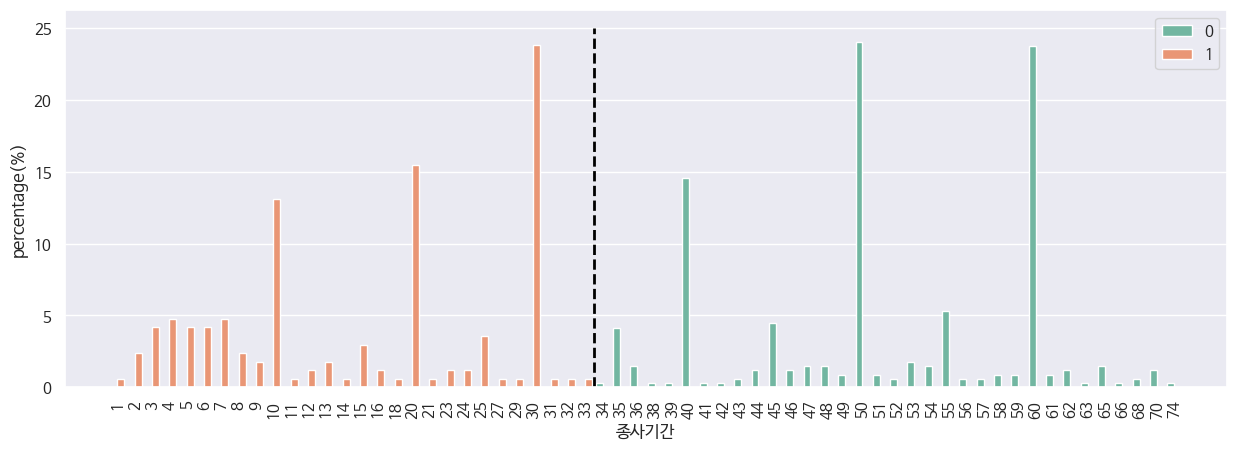

In [22]:
종사기간 = clustering(data, ['종사기간'])
visual_cluster(종사기간, '종사기간', figsize=(15,5))
plt.plot([27.5,27.5], [0,25], 'k--', lw=2)

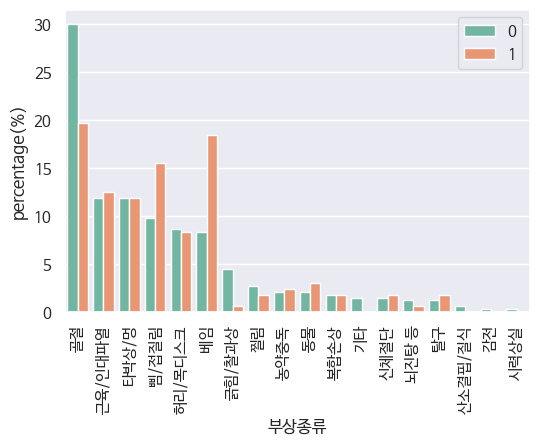

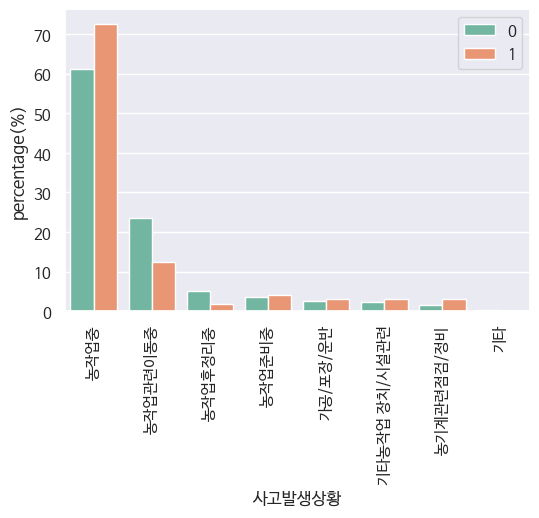

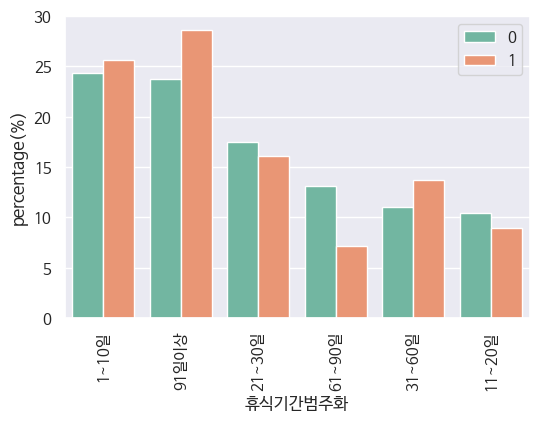

In [23]:
cols = ['부상종류','사고발생상황','휴식기간범주화']
for i in cols:
    visual_cluster(종사기간, i)